In [ ]:
#import required libs
import torch
import torch.nn
#from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [ ]:
inceptionv3 = models.inception_v3(pretrained=True) #download and load pretrained inceptionv3 model
inceptionv3.eval();

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

img = Image.open("/content/do7.PNG").convert('RGB')

In [ ]:
#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

In [ ]:
image_tensor = preprocess(img) #preprocess an i
image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W

In [ ]:
img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

In [ ]:
output = inceptionv3.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
print(label_idx)

717


In [ ]:
labels_link = "https://savan77.github.io/blog/labels.json"    
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[(label_idx)]
print(x_pred)

pickup, pickup truck


In [ ]:
#get probability dist over classes
output_probs = F.softmax(output, dim=1)
x_pred_prob =  (torch.max(output_probs.data, 1)[0][0]) * 100
print(x_pred_prob)

tensor(39.0267)


In [ ]:
y_true = 282   #tiger cat  ##change this if you change input image
target = (Variable(torch.LongTensor([y_true]), requires_grad=False))
print(int(target))

282


In [ ]:
#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)    #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

In [ ]:
eps = 0.02
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = inceptionv3.forward(Variable(x_adversarial))   #perform a forward pass on adv example
x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]    #classify the adv example
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob = (torch.max(op_adv_probs.data, 1)[0][0]) * 100

In [ ]:
print(x_adv_pred)
print(adv_pred_prob)

pickup, pickup truck
tensor(79.8668)


In [ ]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

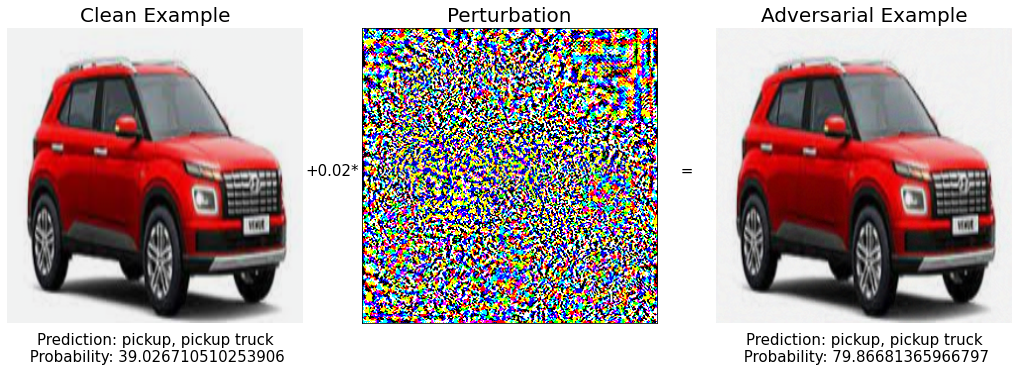

In [ ]:
visualize(image_tensor, x_adversarial, x_grad, eps, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

In [ ]:
epsilon = [0.00088, 0.004, 0.01, 0.12, 0.55]

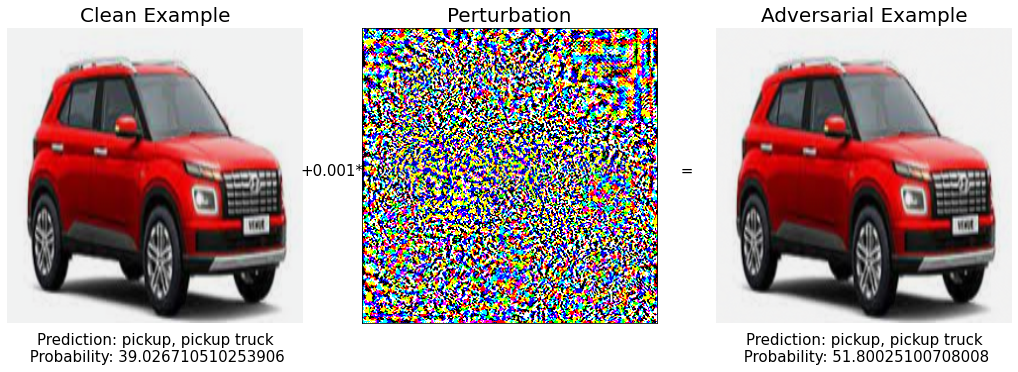

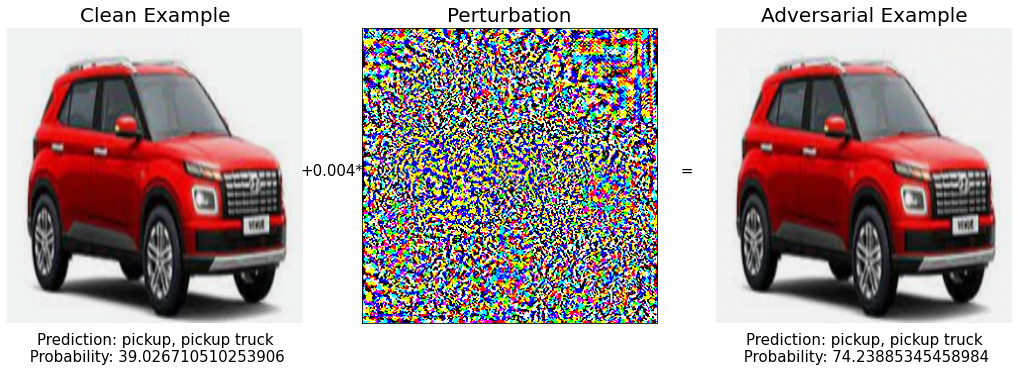

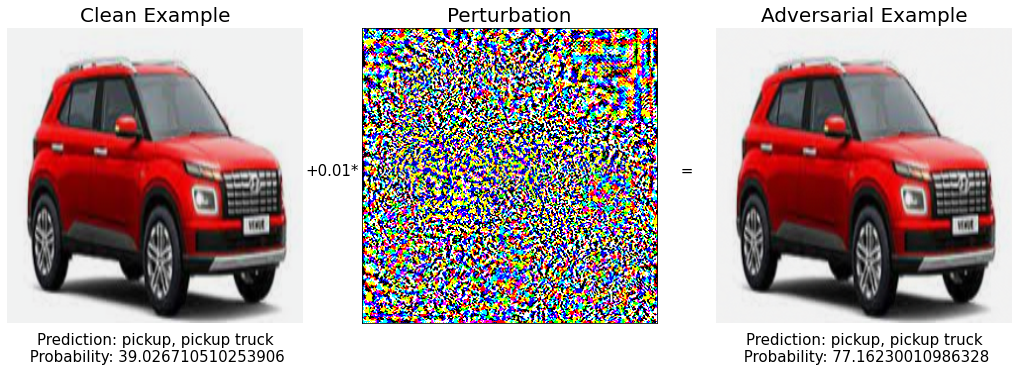

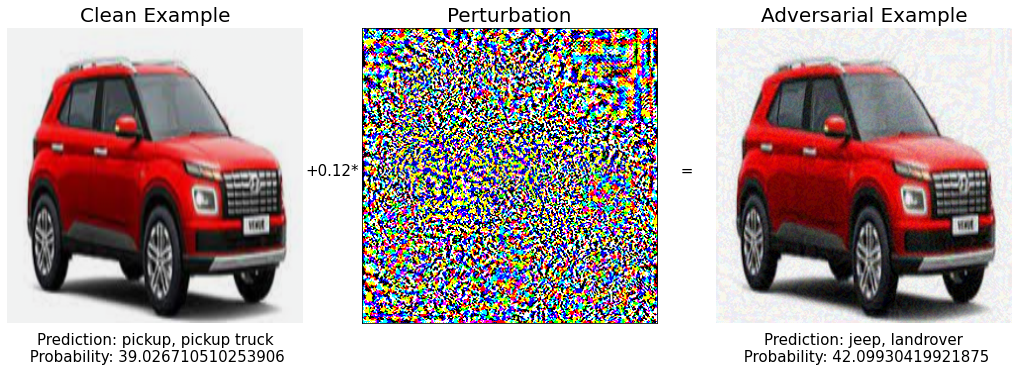

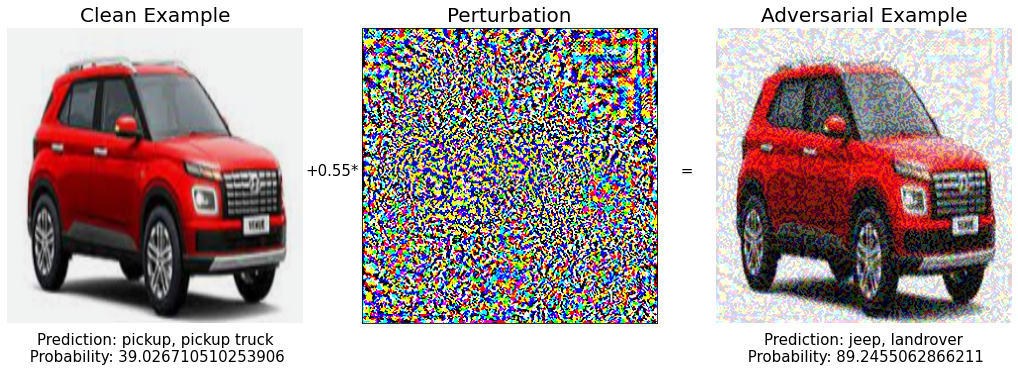

In [ ]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilon:
  x_adversarial = img_variable.data + i * x_grad
  output_adv = inceptionv3.forward(Variable(x_adversarial))
  x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob = (torch.max(op_adv_probs.data, 1)[0][0]) * 100
  visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)